# Library import

In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [2]:
userPATH ='revision_dataset/'
tweetPATH = 'revision_dataset/'

In [3]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [4]:
train_df = pd.read_csv(tweetPATH+'train_df.csv', keep_default_na=False)
test_df = pd.read_csv(tweetPATH+'test_df.csv', keep_default_na=False)
val_df = pd.read_csv(tweetPATH+'val_df.csv', keep_default_na=False)

In [5]:
## prepare data for BERT training and save in newdata/
if not os.path.exists('newdataVote/'): 
    os.mkdir('newdataVote/')
    train_df.to_csv('newdataVote/train.csv', index=False)
    test_df.to_csv('newdataVote/test.csv', index=False)
    val_df.to_csv('newdataVote/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [6]:
!nvidia-smi

Tue Mar 22 05:31:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    57W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    72W / 300W |  16646MiB / 32480MiB |     51%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
torch.cuda.set_device(7)
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:7"
torch.cuda.current_device()

7

In [8]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [9]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indolem/indobertweet-base-uncased')
config = BertConfig.from_pretrained('indolem/indobertweet-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indolem/indobertweet-base-uncased', 
                                                      config=config)

train_dataset = LocationPredictionDataset("newdataVote/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("newdataVote/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("newdataVote/test.csv", tokenizer, lowercase=True)


learning_rate = 2e-5
batch_size = 16
epochs = 7

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)

Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/ind

In [10]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [11]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.cuda()

### training

In [12]:
file_path = 'saved_model_vote/'
if not os.path.exists(file_path): 
    os.mkdir(file_path)

model_name = 'indoBERTweet_model'
metrics_name = 'indoBERTweet_metrics'

model_path = file_path+model_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'
metrics_path = file_path+metrics_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")


# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(model_path, model, optimizer, best_valid_loss)

save_metrics(metrics_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:1.8670 LR:0.00002000: 100%|██████████| 5337/5337 [05:42<00:00, 15.57it/s]


(Epoch 1) TRAIN LOSS:1.8670 ACC:0.31 F1:0.31 REC:0.30 PRE:0.35 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5108 ACC:0.56 F1:0.12 REC:0.09 PRE:0.17:   0%|          | 1/583 [00:01<10:31,  1.09s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9241 ACC:0.72 F1:0.14 REC:0.12 PRE:0.17:   0%|          | 1/583 [00:01<10:31,  1.09s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.3600 ACC:0.55 F1:0.25 REC:0.26 PRE:0.29:   3%|▎         | 17/583 [00:01<00:27, 20.72it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.3639 ACC:0.56 F1:0.26 REC:0.26 PRE:0.29:   4%|▍         | 22/583 [00:01<00:21, 26.08it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.3414 ACC:0.58 F1:0.26 REC:0.26 PRE:0.29:   4%|▍         | 22/583 [00:01<00:21, 26.08it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.5762 ACC:0.46 F1:0.29 REC:0.31 PRE:0.30:   7%|▋         | 41/583 [00:02<00:15, 34.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5755 ACC:0.45 F1:0.28 REC:0.32 PRE:0.30:   7%|▋         | 41/583 [00:02<00:15, 34.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5691 ACC:0.45 F1:0.28 REC:0.32 PRE:0.30:   7%|▋         | 41/583 [00:02<00:15, 34.76it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.6786 ACC:0.38 F1:0.26 REC:0.29 PRE:0.31:  10%|█         | 61/583 [00:02<00:16, 31.72it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6844 ACC:0.38 F1:0.26 REC:0.29 PRE:0.31:  10%|█         | 61/583 [00:02<00:16, 31.72it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6959 ACC:0.37 F1:0.26 REC:0.29 PRE:0.31:  11%|█         | 65/583 [00:02<00:16, 31.21it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8015 ACC:0.33 F1:0.23 REC:0.28 PRE:0.29:  14%|█▍        | 82/583 [00:03<00:19, 25.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8032 ACC:0.33 F1:0.23 REC:0.28 PRE:0.29:  15%|█▍        | 85/583 [00:03<00:19, 25.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8112 ACC:0.33 F1:0.23 REC:0.28 PRE:0.28:  15%|█▍        | 85/583 [00:03<00:19, 25.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 1) VALID LOSS:1.7573 ACC:0.40 F1:0.40 REC:0.39 PRE:0.46


(Epoch 2) TRAIN LOSS:1.5910 LR:0.00002000: 100%|██████████| 5337/5337 [05:47<00:00, 15.37it/s]


(Epoch 2) TRAIN LOSS:1.5910 ACC:0.43 F1:0.43 REC:0.42 PRE:0.45 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8518 ACC:0.38 F1:0.07 REC:0.05 PRE:0.12:   0%|          | 1/583 [00:01<10:38,  1.10s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0730 ACC:0.66 F1:0.10 REC:0.08 PRE:0.12:   0%|          | 1/583 [00:01<10:38,  1.10s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.4542 ACC:0.48 F1:0.24 REC:0.22 PRE:0.30:   3%|▎         | 17/583 [00:01<00:30, 18.74it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4669 ACC:0.49 F1:0.24 REC:0.23 PRE:0.30:   4%|▍         | 22/583 [00:01<00:23, 23.66it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4534 ACC:0.49 F1:0.24 REC:0.23 PRE:0.30:   4%|▍         | 22/583 [00:01<00:23, 23.66it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.6341 ACC:0.42 F1:0.26 REC:0.27 PRE:0.29:   7%|▋         | 41/583 [00:02<00:16, 33.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6279 ACC:0.42 F1:0.26 REC:0.27 PRE:0.29:   7%|▋         | 41/583 [00:02<00:16, 33.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6111 ACC:0.42 F1:0.26 REC:0.27 PRE:0.30:   7%|▋         | 41/583 [00:02<00:16, 33.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.6307 ACC:0.40 F1:0.28 REC:0.29 PRE:0.32:  10%|█         | 61/583 [00:02<00:16, 31.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6373 ACC:0.40 F1:0.27 REC:0.29 PRE:0.32:  10%|█         | 61/583 [00:02<00:16, 31.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6457 ACC:0.40 F1:0.27 REC:0.29 PRE:0.31:  11%|█         | 65/583 [00:02<00:17, 30.24it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7735 ACC:0.35 F1:0.25 REC:0.28 PRE:0.28:  14%|█▍        | 84/583 [00:03<00:18, 26.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7712 ACC:0.35 F1:0.25 REC:0.28 PRE:0.28:  14%|█▍        | 84/583 [00:03<00:18, 26.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7765 ACC:0.35 F1:0.25 REC:0.28 PRE:0.28:  14%|█▍        | 84/583 [00:03<00:18, 26.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 2) VALID LOSS:1.7998 ACC:0.41 F1:0.41 REC:0.40 PRE:0.43


(Epoch 3) TRAIN LOSS:1.4995 LR:0.00002000: 100%|██████████| 5337/5337 [05:48<00:00, 15.32it/s]


(Epoch 3) TRAIN LOSS:1.4995 ACC:0.46 F1:0.46 REC:0.46 PRE:0.48 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2054 ACC:0.38 F1:0.08 REC:0.05 PRE:0.14:   0%|          | 1/583 [00:01<10:27,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.3132 ACC:0.59 F1:0.11 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<10:27,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.4612 ACC:0.48 F1:0.24 REC:0.23 PRE:0.30:   4%|▎         | 21/583 [00:01<00:23, 24.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4574 ACC:0.48 F1:0.24 REC:0.23 PRE:0.30:   4%|▎         | 21/583 [00:01<00:23, 24.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4323 ACC:0.49 F1:0.24 REC:0.23 PRE:0.30:   4%|▎         | 21/583 [00:01<00:23, 24.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.6980 ACC:0.39 F1:0.25 REC:0.26 PRE:0.29:   7%|▋         | 40/583 [00:02<00:16, 32.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6996 ACC:0.39 F1:0.25 REC:0.26 PRE:0.29:   7%|▋         | 40/583 [00:02<00:16, 32.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6876 ACC:0.39 F1:0.25 REC:0.26 PRE:0.29:   8%|▊         | 44/583 [00:02<00:16, 32.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.6833 ACC:0.39 F1:0.26 REC:0.28 PRE:0.30:  10%|█         | 60/583 [00:02<00:17, 30.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6902 ACC:0.39 F1:0.26 REC:0.28 PRE:0.30:  11%|█         | 64/583 [00:02<00:17, 29.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7021 ACC:0.39 F1:0.26 REC:0.28 PRE:0.30:  11%|█         | 64/583 [00:02<00:17, 29.68it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8690 ACC:0.34 F1:0.23 REC:0.27 PRE:0.27:  14%|█▍        | 83/583 [00:03<00:20, 24.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8641 ACC:0.34 F1:0.24 REC:0.28 PRE:0.28:  14%|█▍        | 83/583 [00:03<00:20, 24.85it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8691 ACC:0.33 F1:0.24 REC:0.27 PRE:0.28:  15%|█▍        | 86/583 [00:03<00:20, 24.38it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 3) VALID LOSS:1.8704 ACC:0.41 F1:0.41 REC:0.41 PRE:0.43


(Epoch 4) TRAIN LOSS:1.4022 LR:0.00002000: 100%|██████████| 5337/5337 [05:47<00:00, 15.35it/s]


(Epoch 4) TRAIN LOSS:1.4022 ACC:0.50 F1:0.50 REC:0.50 PRE:0.52 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.4997 ACC:0.31 F1:0.08 REC:0.05 PRE:0.17:   0%|          | 1/583 [00:01<10:17,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4714 ACC:0.56 F1:0.12 REC:0.09 PRE:0.17:   0%|          | 1/583 [00:01<10:17,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.5989 ACC:0.41 F1:0.21 REC:0.19 PRE:0.30:   3%|▎         | 17/583 [00:01<00:29, 19.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6223 ACC:0.41 F1:0.21 REC:0.19 PRE:0.30:   4%|▍         | 22/583 [00:01<00:23, 24.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6431 ACC:0.40 F1:0.21 REC:0.19 PRE:0.28:   4%|▍         | 22/583 [00:01<00:23, 24.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7949 ACC:0.37 F1:0.24 REC:0.25 PRE:0.28:   7%|▋         | 40/583 [00:02<00:16, 33.25it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7855 ACC:0.38 F1:0.24 REC:0.25 PRE:0.28:   7%|▋         | 40/583 [00:02<00:16, 33.25it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7651 ACC:0.38 F1:0.24 REC:0.25 PRE:0.28:   8%|▊         | 44/583 [00:02<00:16, 33.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8203 ACC:0.38 F1:0.26 REC:0.28 PRE:0.32:  10%|█         | 60/583 [00:02<00:16, 31.15it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8275 ACC:0.38 F1:0.26 REC:0.28 PRE:0.32:  11%|█         | 64/583 [00:02<00:17, 30.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8337 ACC:0.38 F1:0.26 REC:0.28 PRE:0.32:  11%|█         | 64/583 [00:02<00:17, 30.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.9513 ACC:0.34 F1:0.25 REC:0.28 PRE:0.30:  14%|█▍        | 83/583 [00:03<00:19, 26.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9411 ACC:0.35 F1:0.25 REC:0.29 PRE:0.30:  14%|█▍        | 83/583 [00:03<00:19, 26.02it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9413 ACC:0.35 F1:0.25 REC:0.28 PRE:0.30:  15%|█▍        | 86/583 [00:03<00:19, 25.49it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 4) VALID LOSS:1.9096 ACC:0.41 F1:0.41 REC:0.41 PRE:0.43


(Epoch 5) TRAIN LOSS:1.3700 LR:0.00002000: 100%|██████████| 5337/5337 [05:47<00:00, 15.34it/s]


(Epoch 5) TRAIN LOSS:1.3700 ACC:0.51 F1:0.51 REC:0.51 PRE:0.53 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0626 ACC:0.50 F1:0.13 REC:0.10 PRE:0.20:   0%|          | 1/583 [00:01<10:30,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.2054 ACC:0.66 F1:0.13 REC:0.11 PRE:0.17:   0%|          | 1/583 [00:01<10:30,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.5699 ACC:0.49 F1:0.23 REC:0.22 PRE:0.28:   4%|▎         | 21/583 [00:01<00:24, 23.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6113 ACC:0.48 F1:0.23 REC:0.22 PRE:0.28:   4%|▎         | 21/583 [00:01<00:24, 23.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6498 ACC:0.47 F1:0.23 REC:0.22 PRE:0.27:   4%|▎         | 21/583 [00:01<00:24, 23.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7724 ACC:0.41 F1:0.28 REC:0.28 PRE:0.30:   7%|▋         | 41/583 [00:02<00:16, 32.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7697 ACC:0.41 F1:0.28 REC:0.28 PRE:0.30:   7%|▋         | 41/583 [00:02<00:16, 32.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7555 ACC:0.41 F1:0.28 REC:0.29 PRE:0.30:   7%|▋         | 41/583 [00:02<00:16, 32.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7540 ACC:0.41 F1:0.29 REC:0.32 PRE:0.33:  10%|█         | 61/583 [00:02<00:17, 30.06it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7683 ACC:0.41 F1:0.30 REC:0.32 PRE:0.33:  10%|█         | 61/583 [00:02<00:17, 30.06it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7816 ACC:0.40 F1:0.29 REC:0.32 PRE:0.33:  11%|█         | 65/583 [00:02<00:17, 29.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8416 ACC:0.38 F1:0.28 REC:0.32 PRE:0.31:  14%|█▍        | 83/583 [00:03<00:21, 23.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8334 ACC:0.38 F1:0.28 REC:0.32 PRE:0.31:  14%|█▍        | 83/583 [00:03<00:21, 23.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8324 ACC:0.38 F1:0.28 REC:0.32 PRE:0.31:  15%|█▍        | 86/583 [00:03<00:21, 22.73it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 5) VALID LOSS:1.9212 ACC:0.42 F1:0.43 REC:0.42 PRE:0.45


(Epoch 6) TRAIN LOSS:1.2778 LR:0.00002000: 100%|██████████| 5337/5337 [05:50<00:00, 15.24it/s]


(Epoch 6) TRAIN LOSS:1.2778 ACC:0.55 F1:0.55 REC:0.54 PRE:0.56 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5619 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:01<10:48,  1.11s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5449 ACC:0.59 F1:0.12 REC:0.10 PRE:0.17:   0%|          | 1/583 [00:01<10:48,  1.11s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.6119 ACC:0.46 F1:0.23 REC:0.21 PRE:0.30:   4%|▎         | 21/583 [00:01<00:24, 22.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6335 ACC:0.45 F1:0.23 REC:0.21 PRE:0.30:   4%|▎         | 21/583 [00:01<00:24, 22.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6493 ACC:0.45 F1:0.23 REC:0.21 PRE:0.30:   4%|▎         | 21/583 [00:01<00:24, 22.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7503 ACC:0.43 F1:0.30 REC:0.31 PRE:0.33:   7%|▋         | 41/583 [00:02<00:16, 32.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7562 ACC:0.42 F1:0.30 REC:0.31 PRE:0.32:   7%|▋         | 41/583 [00:02<00:16, 32.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7455 ACC:0.43 F1:0.30 REC:0.32 PRE:0.32:   7%|▋         | 41/583 [00:02<00:16, 32.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8290 ACC:0.40 F1:0.30 REC:0.34 PRE:0.34:  10%|█         | 61/583 [00:02<00:17, 29.43it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8463 ACC:0.40 F1:0.30 REC:0.34 PRE:0.34:  10%|█         | 61/583 [00:02<00:17, 29.43it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8631 ACC:0.40 F1:0.30 REC:0.34 PRE:0.34:  11%|█         | 65/583 [00:02<00:17, 29.12it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.9492 ACC:0.37 F1:0.28 REC:0.33 PRE:0.31:  14%|█▍        | 83/583 [00:03<00:19, 25.16it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9395 ACC:0.37 F1:0.28 REC:0.34 PRE:0.32:  14%|█▍        | 83/583 [00:03<00:19, 25.16it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9396 ACC:0.37 F1:0.28 REC:0.34 PRE:0.32:  15%|█▍        | 86/583 [00:03<00:21, 23.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 6) VALID LOSS:1.9610 ACC:0.43 F1:0.43 REC:0.42 PRE:0.45


(Epoch 7) TRAIN LOSS:1.2093 LR:0.00002000: 100%|██████████| 5337/5337 [05:46<00:00, 15.39it/s]


(Epoch 7) TRAIN LOSS:1.2093 ACC:0.57 F1:0.58 REC:0.57 PRE:0.59 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0610 ACC:0.50 F1:0.13 REC:0.10 PRE:0.20:   0%|          | 1/583 [00:01<10:27,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.2305 ACC:0.66 F1:0.13 REC:0.11 PRE:0.17:   0%|          | 1/583 [00:01<10:27,  1.08s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.7836 ACC:0.42 F1:0.20 REC:0.19 PRE:0.28:   4%|▎         | 21/583 [00:01<00:23, 23.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8035 ACC:0.41 F1:0.20 REC:0.19 PRE:0.27:   4%|▎         | 21/583 [00:01<00:23, 23.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8267 ACC:0.41 F1:0.20 REC:0.19 PRE:0.26:   4%|▎         | 21/583 [00:01<00:23, 23.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8053 ACC:0.42 F1:0.28 REC:0.29 PRE:0.31:   7%|▋         | 40/583 [00:02<00:16, 33.83it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8060 ACC:0.42 F1:0.28 REC:0.29 PRE:0.31:   7%|▋         | 40/583 [00:02<00:16, 33.83it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7918 ACC:0.42 F1:0.28 REC:0.29 PRE:0.31:   8%|▊         | 44/583 [00:02<00:15, 34.31it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8327 ACC:0.41 F1:0.29 REC:0.32 PRE:0.33:  10%|█         | 60/583 [00:02<00:16, 31.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8535 ACC:0.41 F1:0.29 REC:0.32 PRE:0.34:  11%|█         | 64/583 [00:02<00:16, 30.79it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8730 ACC:0.40 F1:0.29 REC:0.31 PRE:0.33:  11%|█         | 64/583 [00:02<00:16, 30.79it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.9246 ACC:0.38 F1:0.27 REC:0.31 PRE:0.31:  14%|█▍        | 84/583 [00:03<00:18, 26.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9180 ACC:0.38 F1:0.28 REC:0.32 PRE:0.32:  14%|█▍        | 84/583 [00:03<00:18, 26.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9206 ACC:0.38 F1:0.28 REC:0.32 PRE:0.32:  14%|█▍        | 84/583 [00:03<00:18, 26.56it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 7) VALID LOSS:1.9813 ACC:0.42 F1:0.43 REC:0.42 PRE:0.45
Done Training!


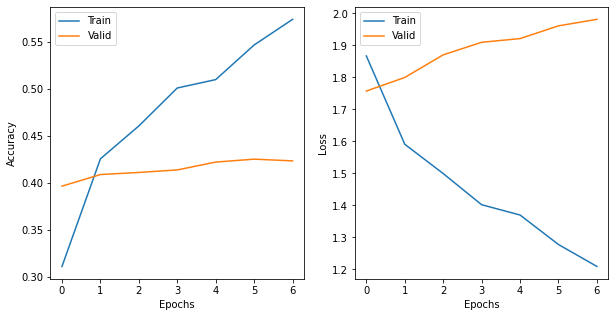

In [14]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(metrics_path)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

### predict

In [15]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indolem/indobertweet-base-uncased')

myconfig = BertConfig.from_pretrained('indolem/indobertweet-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indolem/indobertweet-base-uncased', 
                                                      config=myconfig)


Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/ind

In [16]:
# menggunakan gpu  
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=learning_rate)

load_checkpoint(model_path, best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 1455/1455 [00:23<00:00, 62.63it/s]


In [17]:
## get y_test for user level
y_test_user_lvl = userlvltest.Lvalue
y_test_user_lvl.values

array([8, 6, 3, 0, 4, 1, 7, 4, 5, 1, 1, 7, 3, 5, 7, 0, 2, 4, 4, 2, 6, 2,
       7, 4, 2, 2, 1, 3, 2, 3, 1, 4, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 1,
       7, 4, 2, 3, 6, 0, 3, 4, 4, 3, 1, 5, 4, 0, 0, 2, 0, 4, 0, 3, 3, 3,
       7, 5, 7, 3, 3, 7, 3, 3, 3, 8, 3, 1, 6, 6, 5, 8, 5, 0, 1, 3, 7, 0,
       4, 8, 6, 0, 4, 2, 1, 5, 2, 5, 7, 8, 8, 6, 2, 4, 5, 4, 0, 7, 1, 2,
       0, 1, 8, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 7, 2, 5, 6, 3, 3, 3,
       0, 4, 4, 0, 4, 8, 3, 2, 1, 1, 7, 6, 5, 5, 3, 1, 3, 6, 7, 8, 6, 5,
       2, 0, 2, 6, 1, 6, 8, 0, 7, 7, 1, 0, 4, 8, 8, 0, 6, 2, 4, 6, 4, 2,
       4, 8, 3, 1, 3, 6, 1, 6, 3, 8, 8, 1, 6, 0, 5, 8, 8, 3, 1, 2, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 5, 6, 5, 4, 8, 5, 4, 7, 4, 3, 5,
       3, 8, 5, 2, 6, 8, 8, 5, 4, 4, 3, 7, 5, 2, 3, 0, 8, 1, 2, 1, 3, 4,
       1, 7, 4, 2, 5, 4, 3, 3])

In [18]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes

## get y_pred for user level
pred_tweets_lvl = test_df[['screen_name']].copy()
pred_tweets_lvl['Lpredict'] = y_pred_tweets_lvl.values
""
y_pred_user_lvl = pred_tweets_lvl.groupby(['screen_name'], sort=False).agg(lambda x:x.value_counts().index[0])
y_pred_user_lvl.Lpredict.values

array([1, 1, 1, 1, 3, 1, 7, 0, 5, 2, 1, 7, 3, 2, 7, 0, 2, 1, 3, 2, 6, 2,
       7, 1, 2, 1, 2, 3, 2, 3, 5, 4, 1, 8, 2, 8, 1, 8, 6, 1, 8, 2, 1, 1,
       7, 2, 2, 3, 6, 0, 1, 1, 4, 1, 1, 8, 4, 0, 1, 2, 8, 4, 1, 1, 3, 3,
       2, 5, 2, 2, 3, 7, 3, 3, 2, 8, 3, 2, 6, 8, 5, 8, 2, 1, 1, 3, 2, 0,
       1, 8, 8, 8, 3, 2, 1, 5, 2, 5, 1, 1, 1, 6, 2, 2, 8, 4, 1, 3, 1, 2,
       0, 1, 8, 1, 8, 2, 0, 8, 1, 0, 4, 1, 2, 7, 3, 1, 2, 1, 6, 3, 3, 3,
       8, 3, 4, 0, 4, 2, 1, 2, 1, 1, 2, 1, 5, 8, 3, 1, 2, 1, 1, 2, 6, 1,
       2, 1, 1, 6, 1, 6, 8, 0, 7, 2, 1, 2, 4, 1, 1, 2, 8, 1, 2, 6, 1, 1,
       4, 8, 3, 2, 3, 6, 1, 8, 3, 8, 1, 1, 6, 2, 5, 1, 1, 2, 5, 2, 8, 2,
       1, 1, 2, 2, 4, 6, 2, 2, 8, 4, 0, 2, 1, 2, 1, 8, 2, 4, 1, 1, 2, 2,
       1, 8, 8, 2, 2, 1, 8, 1, 4, 1, 2, 2, 2, 2, 3, 1, 0, 1, 1, 1, 3, 4,
       1, 7, 1, 1, 2, 4, 3, 2])

In [19]:
# y_pred_tweets_lvl.to_csv('bert_result/indoBERTweetTweetslevel.csv')
# y_pred_user_lvl.to_csv('bert_result/indoBERTweet2e_5ResultsVote.csv')

In [20]:
from sklearn.metrics import classification_report, accuracy_score

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_pred_user_lvl, y_test_user_lvl),2 ))
print(classification_report(y_pred_user_lvl, y_test_user_lvl,target_names=label_dict.keys()))

accuracy 0.56
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.38      0.83      0.53        12
               jabodetabek       0.79      0.29      0.43        75
     jawa barat dan banten       0.78      0.42      0.54        60
jawa tengah dan yogyakarta       0.61      0.81      0.70        27
                jawa timur       0.47      1.00      0.64        16
                kalimantan       0.32      0.78      0.45         9
          maluku dan papua       0.57      1.00      0.72        13
                  sulawesi       0.45      1.00      0.62         9
                  sumatera       0.55      0.55      0.55        29

                  accuracy                           0.56       250
                 macro avg       0.55      0.74      0.58       250
              weighted avg       0.66      0.56      0.54       250



### get graph for majority vote

In [21]:
all_pred_tweets_lvl = test_df[['screen_name','isaPerson','userLocation','Lvalue']].copy()
all_pred_tweets_lvl['predicted'] = y_pred_tweets_lvl.values
all_pred_tweets_lvl

,screen_name,isaPerson,userLocation,Lvalue,predicted
0,arshere,person,sumatera,8,1
1,arshere,person,sumatera,8,1
2,arshere,person,sumatera,8,2
3,arshere,person,sumatera,8,2
4,arshere,person,sumatera,8,1
...,...,...,...,...,...
23266,AangMunawar21,person,jawa tengah dan yogyakarta,3,2
23267,AangMunawar21,person,jawa tengah dan yogyakarta,3,2
23268,AangMunawar21,person,jawa tengah dan yogyakarta,3,1
23269,AangMunawar21,person,jawa tengah dan yogyakarta,3,8


In [22]:
df0 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 0].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df1 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 1].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df2 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 2].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)

df3 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 3].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df4 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 4].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df5 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 5].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)

df6 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 6].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df7 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 7].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)
df8 = all_pred_tweets_lvl[all_pred_tweets_lvl.Lvalue == 8].groupby(['screen_name', 'predicted']).size().reset_index().pivot(columns='predicted', index='screen_name', values=0).fillna(0)

In [23]:
sum0 = df0.sum(axis=1)
df0 = df0.div(sum0,axis=0).sort_values(by=0)

sum1 = df1.sum(axis=1)
df1 = df1.div(sum1,axis=0).sort_values(by=1)

sum2 = df2.sum(axis=1)
df2 = df2.div(sum2,axis=0).sort_values(by=2)

sum3 = df3.sum(axis=1)
df3 = df3.div(sum3,axis=0).sort_values(by=3)

sum4 = df4.sum(axis=1)
df4 = df4.div(sum4,axis=0).sort_values(by=4)

sum5 = df5.sum(axis=1)
df5 = df5.div(sum5,axis=0).sort_values(by=5)

sum6 = df6.sum(axis=1)
df6 = df6.div(sum6,axis=0).sort_values(by=6)

sum7 = df7.sum(axis=1)
df7 = df7.div(sum7,axis=0).sort_values(by=7)

sum8 = df8.sum(axis=1)
df8 = df8.div(sum8,axis=0).sort_values(by=8)

In [24]:
cm_names = {
    0:'NU',
    1:'JBD',
    2:'JB&BT',
    3:'JT&YO',
    4:'JI',
    5:'KA',
    6:'ML&PP',
    7:'SL',
    8:'SM'
}

cm_names_sorted = dict(sorted(cm_names.items(), key=lambda item: item[1]))
print(cm_names_sorted)

{2: 'JB&BT', 1: 'JBD', 4: 'JI', 3: 'JT&YO', 5: 'KA', 6: 'ML&PP', 0: 'NU', 7: 'SL', 8: 'SM'}


In [25]:
cm_names_reindex = {
    0:'JB&BT', 1:'JBD', 2:'JI',
    3:'JT&YO', 4:'KA', 5:'ML&PP',
    6:'NU', 7:'SL',8:'SM'}

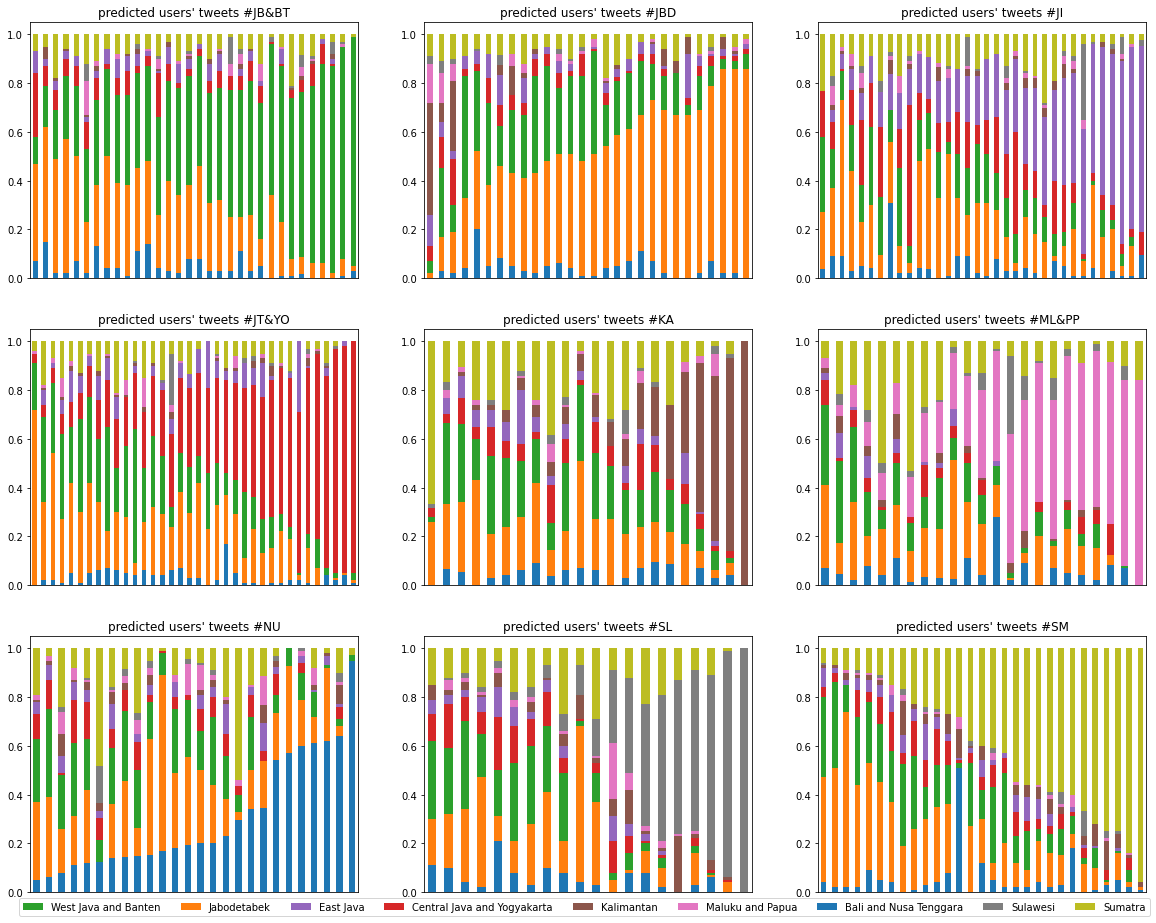

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16))

for i, ax in enumerate(axes.ravel()): # 
    ax.set_title("predicted users' tweets #{}".format(cm_names_reindex [i])) # 3

toPlot = [df2, df1, df4]
for index, frame in enumerate(toPlot):
    ax = frame.plot(kind='bar', stacked=True, ax=axes[0,index], use_index=False, legend=False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
toPlot = [df3, df5, df6]
for index, frame in enumerate(toPlot):
    ax = frame.plot(kind='bar', stacked=True, ax=axes[1,index], use_index=False, legend=False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
toPlot = [df0, df7, df8]
for index, frame in enumerate(toPlot):
    ax = frame.plot(kind='bar', stacked=True, ax=axes[2,index], use_index=False, legend=False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)


    
handles, labels = plt.gca().get_legend_handles_labels()

labels = ['Bali and Nusa Tenggara', 'Jabodetabek', 'West Java and Banten',
                                      'Central Java and Yogyakarta', 
                                      'East Java', 'Kalimantan','Maluku and Papua',
                                     'Sulawesi','Sumatra']

order = [2,1,4,3,5,6,0,7,8]

fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=[0.51, 0.1], loc='lower center', ncol=9)


plt.show()

In [72]:
df1

predicted,0,1,2,3,4,5,6,7,8
screen_name,,,,,,,,,
beINSPORTSid,0.000000,0.020000,0.050000,0.060000,0.130000,0.460000,0.16,0.030000,0.090000
JCIndonesia,0.030000,0.140000,0.280000,0.130000,0.060000,0.080000,0.12,0.050000,0.110000
antvbola,0.020000,0.170000,0.110000,0.190000,0.030000,0.290000,0.07,0.020000,0.100000
DanyBeler,0.040000,0.290000,0.500000,0.030000,0.050000,0.000000,0.00,0.000000,0.090000
pegipegi,0.200000,0.320000,0.330000,0.030000,0.050000,0.000000,0.00,0.010000,0.060000
14045archie,0.050000,0.330000,0.340000,0.100000,0.100000,0.000000,0.00,0.000000,0.080000
nuicemedia,0.083333,0.375000,0.166667,0.083333,0.125000,0.041667,0.00,0.041667,0.083333
humasbatan,0.050000,0.380000,0.260000,0.060000,0.000000,0.120000,0.05,0.000000,0.080000
vincentrompies,0.030000,0.380000,0.260000,0.050000,0.100000,0.020000,0.04,0.000000,0.120000


In [73]:
all_pred_tweets_lvl[all_pred_tweets_lvl.screen_name == 'angga_fzn']

,screen_name,isaPerson,userLocation,Lvalue,predicted


In [87]:
check = all_pred_tweets_lvl[all_pred_tweets_lvl.screen_name == 'angga_fzn']
check['tweets'] = test_df[test_df.screen_name=='angga_fzn'].full_text

check.to_csv('okee.csv')

/tmp/ipykernel_76488/3293384619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check['tweets'] = test_df[test_df.screen_name=='angga_fzn'].full_text
